In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler  
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
df_train = pd.read_csv('train.csv')
df_train_abst  = df_train[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]

df_train_abst.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,208500,7,1710,2,856,2,2003
1,181500,6,1262,2,1262,2,1976
2,223500,7,1786,2,920,2,2001
3,140000,7,1717,3,756,1,1915
4,250000,8,2198,3,1145,2,2000


In [10]:
#目的変数と説明変数に分ける
y_pred = df_train_abst[['SalePrice']]
X = df_train_abst[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]

In [11]:
#形を眺める用の関数を定義する

def scatter(y_pred, y):
    plt.gca().set_aspect('equal', adjustable='box')  # 縦横比を1
    plt.ylabel('y_test(true)')
    plt.xlabel('y_pred')
    plt.plot([y.min(), y.max()], [y.min(), y.max()])  # 斜め45度の青い線
    plt.plot(y_pred, y, '.')

In [30]:
# 評価スコアを定義
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score,make_scorer, mean_squared_error

def rmsle(y, y_pred):
     #return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())
        return np.sqrt((( (np.log1p(y_pred)- np.log1p(y)) )**2).mean())

scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y_pred):
     return (cross_val_score(model, X, y_pred, scoring=scorer, cv = 20)).mean()


In [16]:
# トレーニングデータとテストデータに分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_pred, random_state=0)

# 1.重回帰分析

In [6]:
from sklearn.linear_model import LinearRegression
%precision 3

'%.3f'

In [5]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
# 線形回帰の作成
lr = LinearRegression()
# フィッティング
lr.fit(X_train, y_train)
# パラメータ（定数項と係数）の確認
lr.intercept_, lr.coef_

(array([-818781.365]),
 array([[18463.08 ,    60.859, 12747.263,    39.865, -7956.321,   376.835]]))

In [25]:
# 予測値
y_pred = lr.predict(X_test)

In [34]:
# 決定係数
score1 = r2_score(y_test, y_pred)
score1

0.683

In [35]:
# RMS
score2 = rmsle(y_test, y_pred)
score2

SalePrice    0.224103
dtype: float64

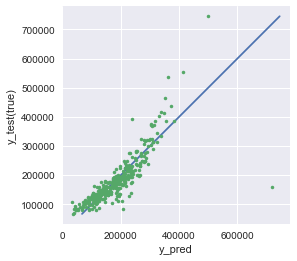

In [36]:
# 予測データ（y_pred）と真値（y_test）を描画
scatter(y_pred, y_test)

### なんか、Priceが上がれば上がるほど外れる傾向にある

# 2. ロバスト回帰
外れ値の影響を減らしたロバスト回帰を試してみる

In [37]:
from sklearn.linear_model import RANSACRegressor

# RANSACの作成
ran = RANSACRegressor(min_samples=int(len(X_train) * 0.9),
                      random_state=0)
# フィッティング
ran.fit(X_train, y_train)
# パラメータ（定数項と係数）の確認
ran.estimator_.intercept_, ran.estimator_.coef_

(array([-783078.212]),
 array([[15171.347,    57.738, 11845.833,    38.546, -6418.95 ,   370.379]]))

In [75]:
# 予測値
y_pred = ran.predict(X_test)
# 決定係数
score3 = r2_score(y_test, y_pred)
score3

0.68965

In [41]:
# RMS
score4 = rmsle(y_test, y_pred)
score4

SalePrice    0.199775
dtype: float64

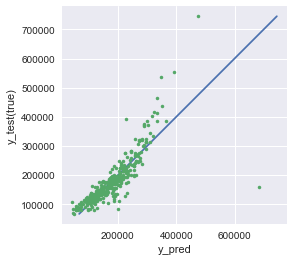

In [39]:
# 予測データ（y_pred）と真値（y_test）を描画
scatter(y_pred, y_test)

微妙に良くなったけど、どうなんだろう。

# 3. 正則化 ~Ridge, LASSO, Elastic Net回帰

In [46]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

In [49]:
# 線形回帰
lr = LinearRegression()
lr.fit(X_train, y_train)
# Ridge回帰
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [50]:
#Lasso回帰
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

#Elastic Net回帰
enet = ElasticNet(alpha=1, l1_ratio = 0.5)
enet.fit(X_train, y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [54]:
# 線形回帰の予測
y_pred1 = lr.predict(X_test)
# 線形回帰の評価
score1 = r2_score(y_test, y_pred1)
# Ridge回帰の予測
y_pred2 = ridge.predict(X_test)
# Ridge回帰の評価
score2 = r2_score(y_test, y_pred2)

# Lassoの予測
y_pred3 = lasso.predict(X_test)
# Lassoの評価
score3 = r2_score(y_test, y_pred3)
# Elastic Netの予測
y_pred4 = enet.predict(X_test)
# Elastic Netの評価
score4 = r2_score(y_test, y_pred4)
score1, score2, score3, score4

(0.683, 0.683, 0.683, 0.649)

In [56]:
lasso.coef_

array([18462.041,    60.857, 12743.997,    39.867, -7948.643,   376.833])

決定係数の値ほぼ変わんね。笑

In [58]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'median_absolute_error', 'mean_absolute_error', 'mean_squared_error', 'accuracy', 'roc_auc', 'average_precision', 'log_loss', 'neg_log_loss', 'adjusted_rand_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [62]:
from sklearn.linear_model import RidgeCV
# αの探索
ridge = RidgeCV(scoring='mean_squared_error')
ridge.fit(X_test, y_pred)
ridge.alpha_

0.100

In [68]:
# さらにαの探索
%precision 5

ridge = RidgeCV([0.00001, 0.0001, 0.001, 0.01, 0.1], scoring='mean_squared_error')
ridge.fit(X_test, y_pred)
ridge.alpha_

0.00001

In [71]:
# 係数の確認
ridge.coef_

array([[15171.35036,    59.24594, 11845.83438,    39.85986, -6418.94749,
          370.42474]])

## 2.ロバスト回帰を採用！